In [1]:
import numpy as np
import os

import pandas as pd
from astropy.io import fits
from astropy import units as u
from astropy.modeling import models
from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII
from IPython.display import Image
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_lines
from specutils.analysis import centroid, line_flux, equivalent_width

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ksf293/anomalies-GAN-HSC/analysis')
import plotter

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)
%matplotlib inline

In [3]:
base_dir = '/scratch/ksf293/anomalies'
#plot_dir = '/home/ksf293/anomalies-GAN-HSC/plots/plots_2021-03-10'
plot_dir = '/home/ksf293/anomalies-GAN-HSC/papers/paper_main/images'

## Bluecore images

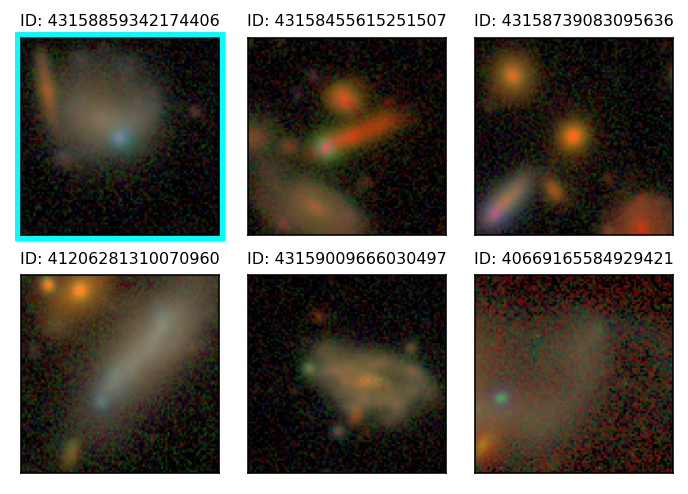

In [4]:
bluecore_ids = [936569, 935055, 936288,
                549909, 937346, 404105]
saveto=f'{plot_dir}/bluecores.png'
plotter.plot_ims(bluecore_ids, 2, 3, imtag='gri', border_indices=[0,0], saveto=saveto)

## Bluedot spectra

In [5]:
hdul = fits.open('../data/keck_data/bluedot/bluedot_coadd.fits')

In [6]:
info = hdul.info()
hdr = hdul[0].header
data = hdul[1].data
w = data['wave']
f = data['flux']

Filename: ../data/keck_data/bluedot/bluedot_coadd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2223,)   uint8   
  1  /Users/yifei/Dropbox/Keck_Data/data4kate_reduced/bluedot/keck_dei...    1 BinTableHDU     20   8109R x 4C   [D, D, D, K]   


In [7]:
#from here http://classic.sdss.org/dr6/algorithms/linestable.html
line_dict = {r'H$\alpha$':6564.61, r'H$\beta$':4862.68, 'OIIIa':4364.436, 'OIIIb':4932.603, 'OIIIc':4960.295, 
             'OIIId':5008.240, 'NIIa':6549.86, 'NIIb':6585.27, 'SIIa':6718.29, 'SIIb':6732.67}

In [8]:
# Redshift via fits by X Prochaska
# (https://docs.google.com/document/d/10n5E8VDJrd3xSTXbU-RvsNgrjl6vjcoLdYiE35Fg0tw/edit)
z=0.03221 
wave = w*u.AA / (1+z)
flux = f*10**-17 * u.Unit('erg cm-2 s-1 AA-1') #??
spec_norm = Spectrum1D(spectral_axis=wave, flux=flux, redshift=z) 
spec_norm_cont = spec_norm / fit_generic_continuum(spec_norm)(spec_norm.spectral_axis) - spec_norm/spec_norm

(-5.0, 20.0)

<Figure size 432x288 with 0 Axes>

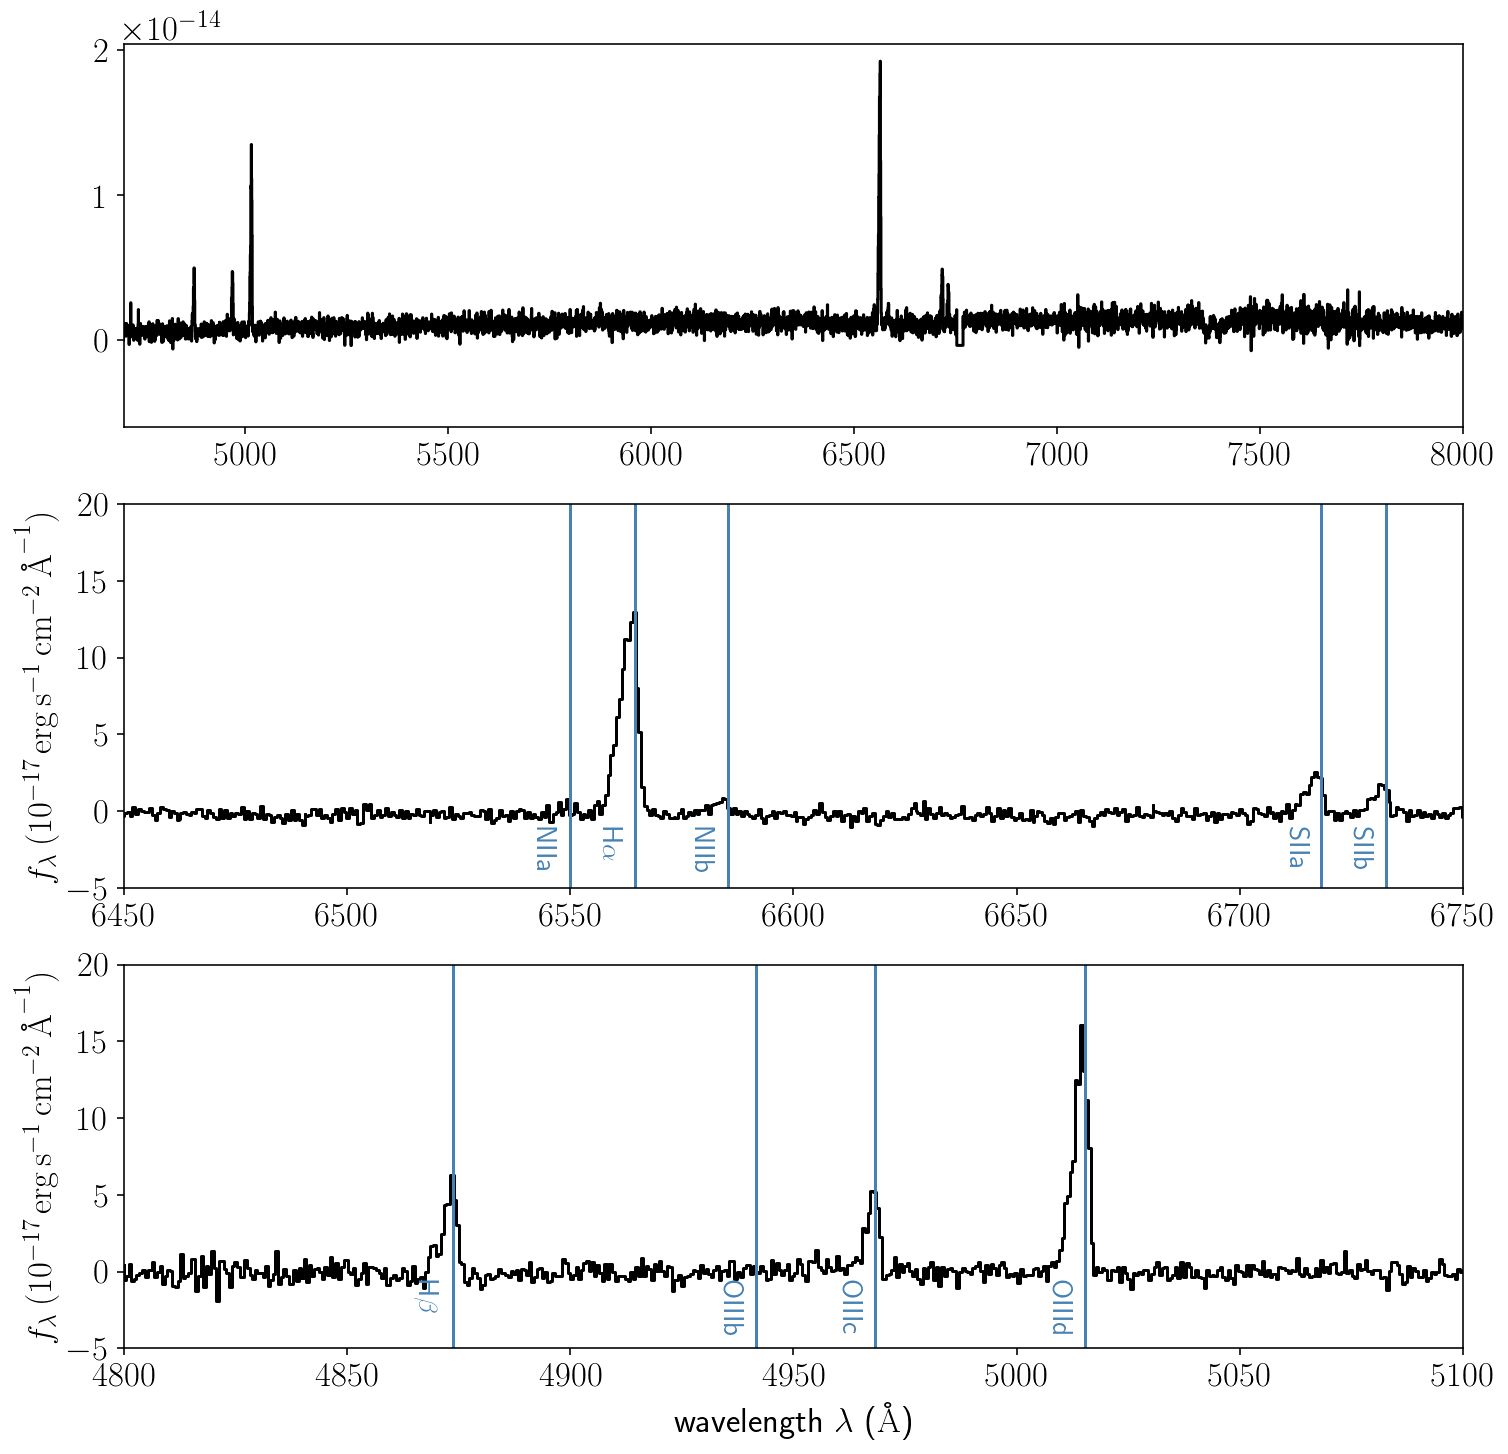

In [9]:
plt.figure()
fig, axarr = plt.subplots(3, 1, figsize=(12,12))
ax0, ax1, ax2 = axarr

# Full spectrum
ax0.step(spec_norm.wavelength, spec_norm.flux, color='black') 
ax0.set_xlim(4700, 8000)

# Halpha region
ax1.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
xmin, xmax = 6450,6750
for line in line_dict:
    wline = line_dict[line]
    if xmin<wline<xmax:
        ax1.axvline(wline, color='steelblue')
        ax1.text(wline-3, -1, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
ax1.set_xlim(xmin, xmax)

# Hbeta region
ax2.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
w_corrections = {r'H$\beta$':11, 'OIIIb':9, 'OIIIc':8, 
             'OIIId':7}
xmin, xmax = 4800,5100
for line in w_corrections:
    wline = line_dict[line] + w_corrections[line]
    if xmin<wline<xmax:
        ax2.axvline(wline, color='steelblue')
        ax2.text(wline-3, -0.5, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
ax2.set_xlim(xmin, xmax)

# all labels and ylimits
xlabel = r'wavelength $\lambda$ ($\mathrm{\AA}$)'
ax2.set_xlabel(xlabel)
ylabel = r'$f_\lambda \: (10^{-17} \, \mathrm{erg} \, \mathrm{s}^{-1} \, \mathrm{cm}^{-2} \, \mathrm{\AA}^{-1})$'
#ax0.set_ylabel(ylabel)
ax1.set_ylabel(ylabel)
ax2.set_ylabel(ylabel)

ymin, ymax = -5, 20
#ax0.set_ylim(ymin, ymax)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

## basic fits

In [10]:
line = r'H$\alpha$'
region_width = 12.0
wmin = (line_dict[line]-region_width/2)*u.AA
wmax = (line_dict[line]+region_width/2)*u.AA
flux_halpha = line_flux(spec_norm_cont, SpectralRegion(wmin, wmax))
ew_halpha = equivalent_width(spec_norm_cont, regions=SpectralRegion(wmin, wmax))
print(flux_halpha)

line = 'NIIb'
region_width = 10.0
wmin = (line_dict[line]-region_width/2)*u.AA
wmax = (line_dict[line]+region_width/2)*u.AA
flux_nII = line_flux(spec_norm_cont, SpectralRegion(wmin, wmax))
ew_nII = equivalent_width(spec_norm_cont, regions=SpectralRegion(wmin, wmax))
print(flux_nII)

59.51144780278862 Angstrom
2.1787532611731275 Angstrom


In [11]:
line = r'H$\beta$'
region_width = 10.0*u.AA
wfix = (line_dict[line]+w_corrections[line])*u.AA # fix offset 
wmin = (wfix-region_width/2)
wmax = (wfix+region_width/2)
flux_hbeta = line_flux(spec_norm_cont, SpectralRegion(wmin, wmax))
ew_hbeta = equivalent_width(spec_norm_cont, regions=SpectralRegion(wmin, wmax))

line = 'OIIId'
region_width = 14.0*u.AA
wfix = (line_dict[line]+w_corrections[line])*u.AA # fix offset
wmin = (wfix-region_width/2)
wmax = (wfix+region_width/2)
flux_oIII = line_flux(spec_norm_cont, SpectralRegion(wmin, wmax))
ew_oIII = equivalent_width(spec_norm_cont, regions=SpectralRegion(wmin, wmax))

## Attempt at double Gaussian fitting

In [12]:
def double_gaussian_fit(spec, line_name, amp0, std0, amp1, std1, show_fig=False):
    mean = line_dict[line_name]
    if line_name in w_corrections:
        mean += w_corrections[line_name]
    g1_init = models.Gaussian1D(amplitude=amp0, mean=mean*u.Angstrom, stddev=std0*u.Angstrom)
    g2_init = models.Gaussian1D(amplitude=amp1, mean=mean*u.Angstrom, stddev=std1*u.Angstrom)

    g12_fit = fit_lines(spec, g1_init+g2_init)#, window=(6558, 6570))
    y_fit = g12_fit(spec.wavelength)
    g1 = models.Gaussian1D(g12_fit.amplitude_0, g12_fit.mean_0, g12_fit.stddev_0)
    g2 = models.Gaussian1D(g12_fit.amplitude_1, g12_fit.mean_1, g12_fit.stddev_1)

    y1_fit = g1(spec.wavelength.value)
    y2_fit = g2(spec.wavelength.value)

    plt.figure(figsize=(4,3))
    plt.plot(spec.wavelength, spec.flux, color='k')
    plt.plot(spec.wavelength, y_fit, color='steelblue')
    plt.plot(spec.wavelength, y1_fit, color='orchid', ls='--')
    plt.plot(spec.wavelength, y2_fit, color='orchid', ls='--')

    xmin, xmax = line_dict[line_name]-20, line_dict[line_name]+20
    plt.xlim(xmin, xmax)
    
    return g12_fit, g1, g2, plt.gca()

In [13]:
fit_dict = {}

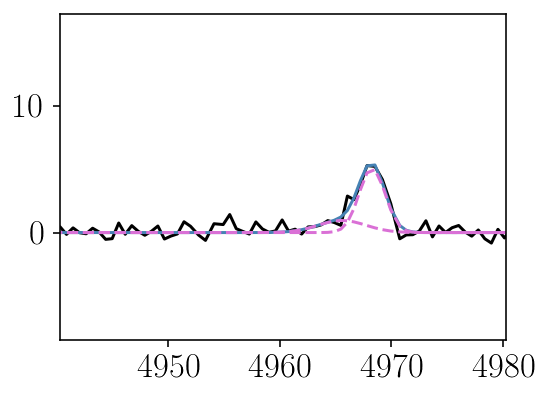

In [14]:
line_name = 'OIIIc'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 4, 2, 3, 1, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

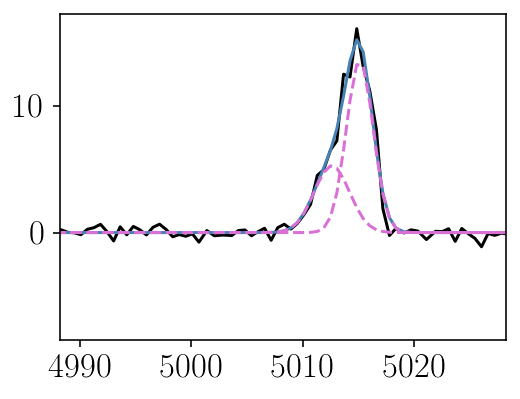

In [15]:
line_name = 'OIIId'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 10, 2, 3, 2, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

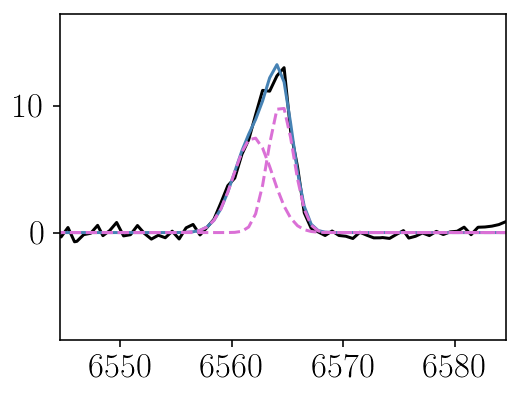

In [16]:
line_name = r'H$\alpha$'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 11, 4, 4, 4, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

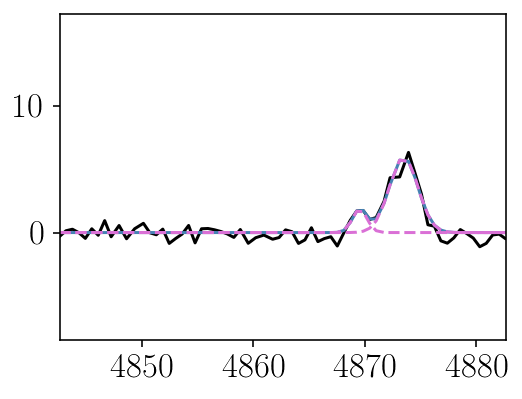

In [17]:
line_name = r'H$\beta$'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 5, 2, 2, 1, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

<QuantityModel CompoundModel(amplitude_0=0.42368166, mean_0=6582.93796274, stddev_0=1.34174194, amplitude_1=0.76134589, mean_1=6584.75091167, stddev_1=0.60201991), input_units=Angstrom, return_units=>


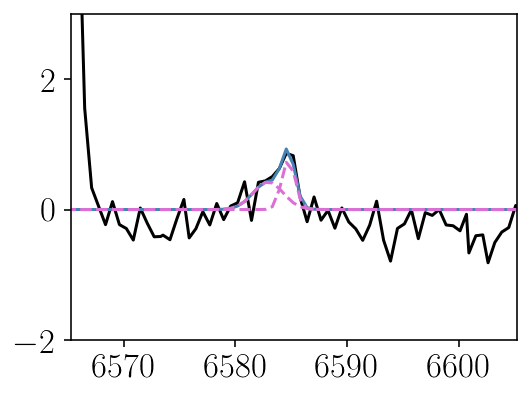

In [18]:
line_name = 'NIIb'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 1.5, 1, 1, 1, show_fig=True)
print(g12_fit)
ax.set_ylim(-2, 3)
fit_dict[line_name] = [g12_fit, g1, g2]

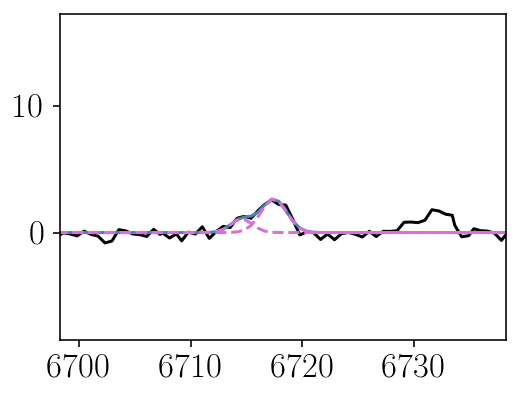

In [19]:
line_name = 'SIIa'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 3, 2, 2, 1, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

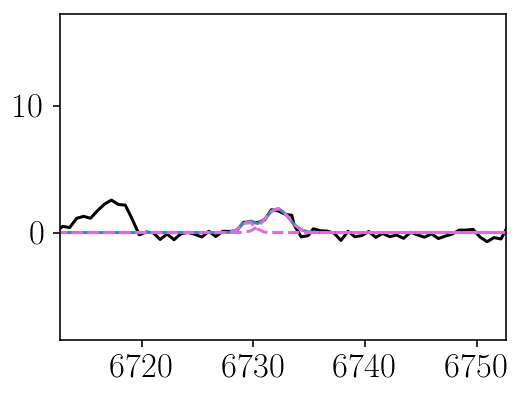

In [20]:
line_name = 'SIIb'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 3, 2, 2, 1, show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

In [21]:
def integrate(g12_fit, spec):
    xmin, xmax = g12_fit.mean_0 - 20, g12_fit.mean_0 + 20
    xs = np.linspace(xmin, xmax, 1000)
    y_fit = g12_fit(xs*u.Angstrom)
    return np.trapz(y_fit, xs)

In [22]:
gflux_nII = integrate(fit_dict['NIIb'][0], spec_norm_cont)
gflux_halpha = integrate(fit_dict[r'H$\alpha$'][0], spec_norm_cont)
gflux_oIII = integrate(fit_dict['OIIId'][0], spec_norm_cont)
gflux_hbeta = integrate(fit_dict[r'H$\beta$'][0], spec_norm_cont)

In [23]:
print(flux_nII, gflux_nII)
print(flux_halpha, gflux_halpha)
print(flux_oIII, gflux_oIII)
print(flux_hbeta, gflux_hbeta)

2.1787532611731275 Angstrom 2.5738481323470728
59.51144780278862 Angstrom 61.62558009998419
60.88549238492224 Angstrom 61.682239261499234
20.566838738955628 Angstrom 22.002747445470817


## BPT diagram

-1.436392465796389
-1.3791781022890355


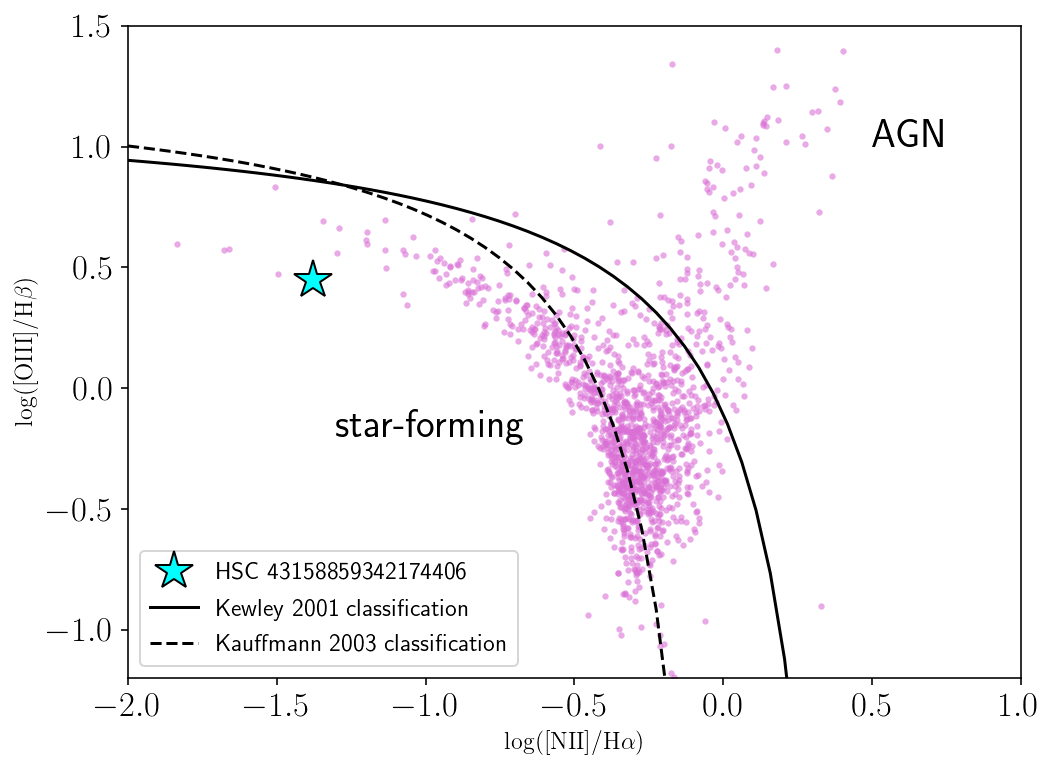

In [24]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))

# line fluxes
fratio1 = np.log10(flux_nII/flux_halpha)
fratio2 = np.log10(flux_oIII/flux_hbeta)
print(fratio1)
# gaussian fluxes 
fratio1 = np.log10(gflux_nII/gflux_halpha)
print(fratio1)
fratio2 = np.log10(gflux_oIII/gflux_hbeta)

plt.plot(fratio1, fratio2, marker='*', 
         color='cyan', markeredgecolor='black', markersize=20, ls='None', label='HSC 43158859342174406')

# 4000 SDSS spectra from the main galaxy sample
# https://github.com/astroML/astroML/blob/c0550bd9cea4aaed3d351494924e65728ad61666/astroML/datasets/sdss_corrected_spectra.py
data = fetch_sdss_corrected_spectra()

i = np.where((data['lineindex_cln'] == 4) | (data['lineindex_cln'] == 5))

# plt.scatter(data['log_NII_Ha'][i], data['log_OIII_Hb'][i],
#             c=data['lineindex_cln'][i], s=9, lw=0)
plt.scatter(data['log_NII_Ha'][i], data['log_OIII_Hb'][i],
             c='orchid', alpha=0.6, s=10, lw=0)

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k', label='Kewley 2001 classification')
#plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
#plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')

ka03 = 0.61/(NII-0.05) + 1.3
idx = [i for i in range(len(NII)) if NII[i]<0 ]
plt.plot(NII[idx], ka03[idx], '--k', label='Kauffmann 2003 classification')

plt.xlim(-2.0, 1.0)
plt.ylim(-1.2, 1.5)
plt.legend(loc='lower left', **{'fontsize': 12})

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.text(0.5, 1, "AGN", fontsize=20)
plt.text(-1.3, -0.2, "star-forming", fontsize=20)

plt.savefig(f'{plot_dir}/bpt.png', bbox_inches='tight')

# Spectra with fits

<Figure size 432x288 with 0 Axes>

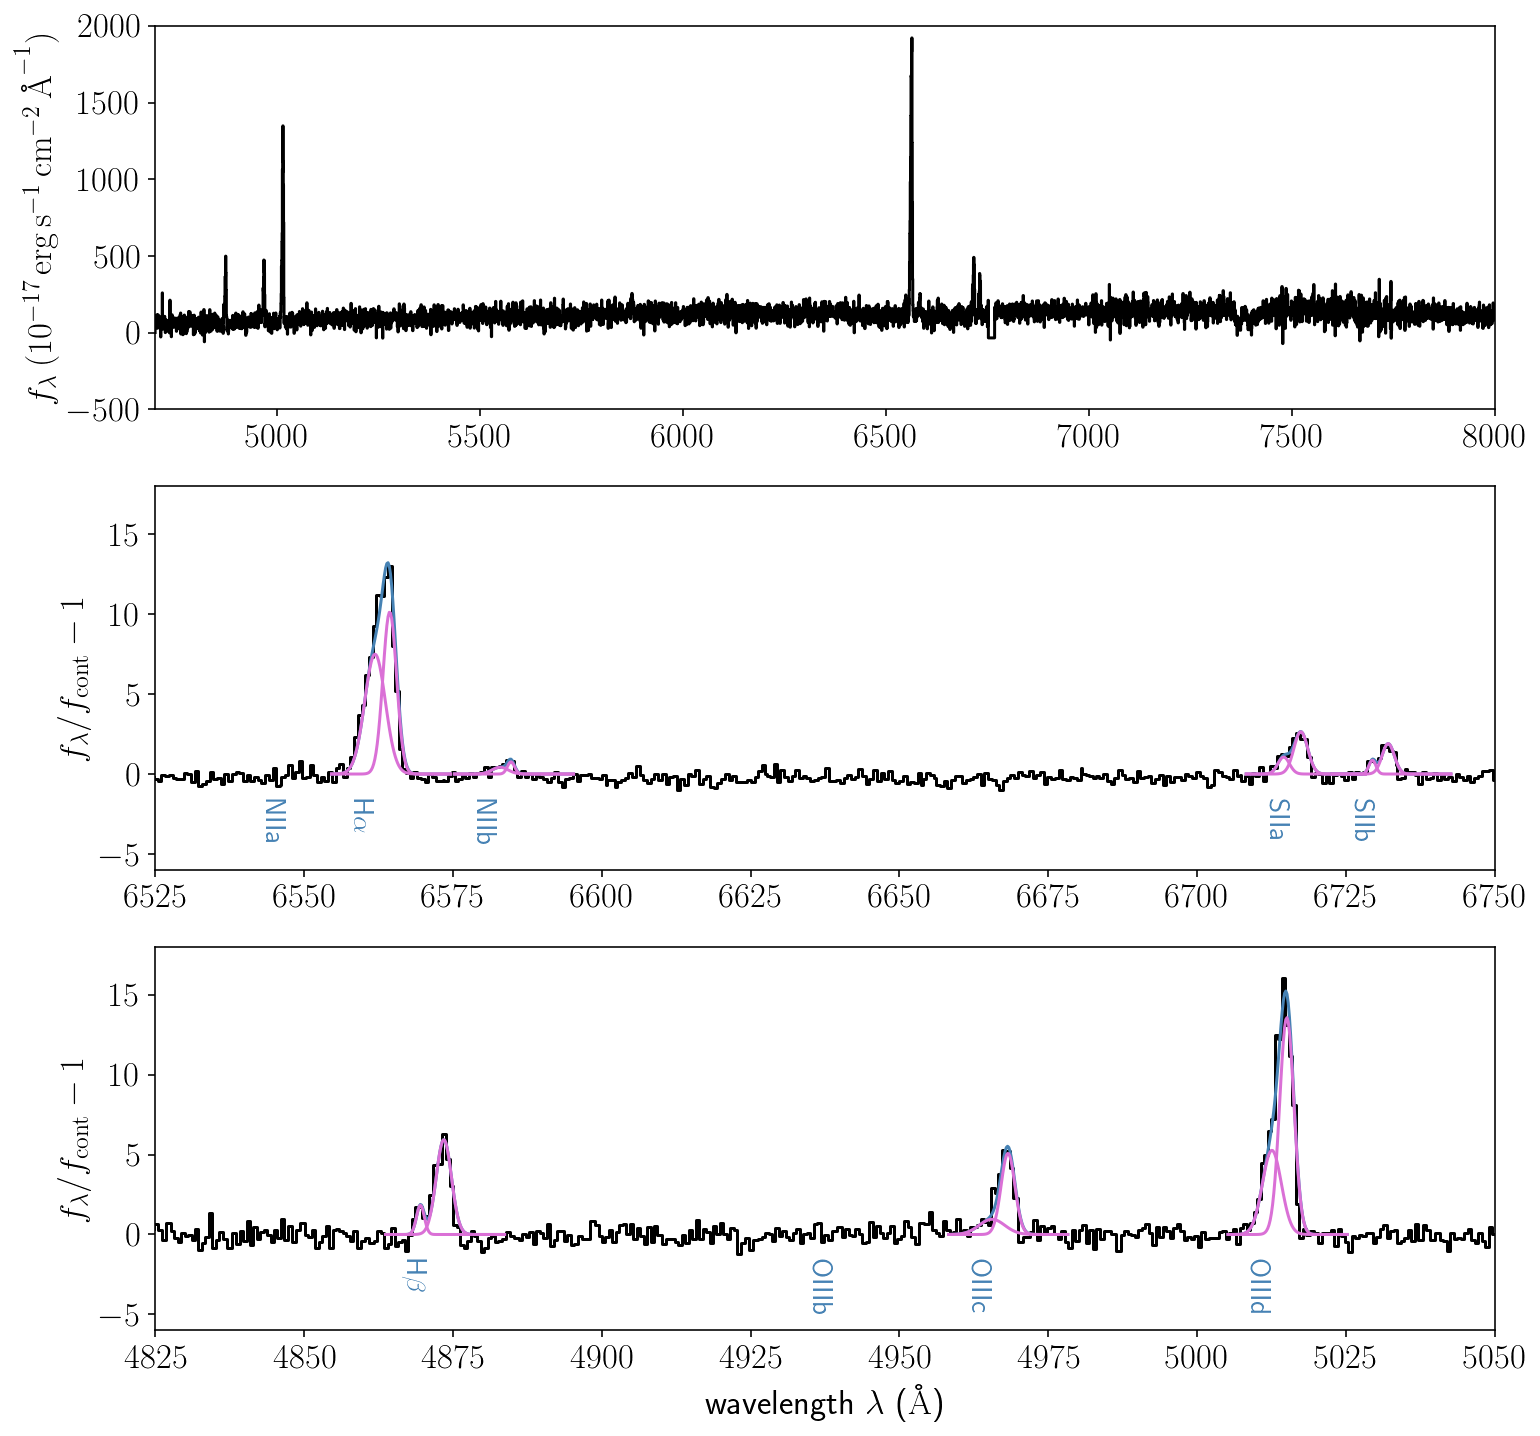

In [25]:
plt.figure()
fig, axarr = plt.subplots(3, 1, figsize=(12,12))
ax0, ax1, ax2 = axarr

# Full spectrum
ax0.step(spec_norm.wavelength, spec_norm.flux/1e-17, color='black') 
ax0.set_xlim(4700, 8000)
ax0.set_ylim(-500, 2000)

# Halpha region
ax1.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
xmin, xmax = 6525,6750
for line in line_dict:
    wline = line_dict[line]
    if xmin<wline<xmax:
        #ax1.axvline(wline, color='steelblue')
        ax1.text(wline-3, -1.5, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
        # fits
        if line in fit_dict:
            g12, g1, g2 = fit_dict[line]
            xplot = np.linspace(wline-10, wline+10, 100)
            y_fit = g12(xplot*u.Angstrom)
            y1_fit = g1(xplot)
            y2_fit = g2(xplot)

            ax1.plot(xplot, y_fit, color='steelblue', lw=1.5)
            ax1.plot(xplot, y1_fit, color='orchid')
            ax1.plot(xplot, y2_fit, color='orchid')
ax1.set_xlim(xmin, xmax)

# Hbeta region
ax2.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
w_corrections = {r'H$\beta$':11, 'OIIIb':9, 'OIIIc':8, 
             'OIIId':7}
xmin, xmax = 4825,5050
for line in w_corrections:
    wline = line_dict[line] + w_corrections[line]
    if xmin<wline<xmax:
        #ax2.axvline(wline, color='steelblue')
        ax2.text(wline-3, -1.5, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
        # fits
        if line in fit_dict:
            g12, g1, g2 = fit_dict[line]
            xplot = np.linspace(wline-10, wline+10, 100)
            y_fit = g12(xplot*u.Angstrom)
            y1_fit = g1(xplot)
            y2_fit = g2(xplot)

            ax2.plot(xplot, y_fit, color='steelblue', lw=1.5)
            ax2.plot(xplot, y1_fit, color='orchid')
            ax2.plot(xplot, y2_fit, color='orchid')
ax2.set_xlim(xmin, xmax)

# all labels and ylimits
xlabel = r'wavelength $\lambda$ ($\mathrm{\AA}$)'
ax2.set_xlabel(xlabel)
ylabel = r'$f_\lambda \: (10^{-17} \, \mathrm{erg} \, \mathrm{s}^{-1} \, \mathrm{cm}^{-2} \, \mathrm{\AA}^{-1})$'
ylabel_fnorm = r'$f_\lambda/f_\mathrm{cont} - 1$'
ax0.set_ylabel(ylabel)
ax1.set_ylabel(ylabel_fnorm)
ax2.set_ylabel(ylabel_fnorm)

ymin, ymax = -6, 18
#ax0.set_ylim(ymin, ymax)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

plt.savefig(f'{plot_dir}/spectra.png', bbox_inches='tight')

## Color-color diagram

In [26]:
info_fn = '../data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv'
cols = ['idx', 'ra_x', 'dec_x', 'object_id', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag']
info_df = pd.read_csv(info_fn, usecols=cols, squeeze=False)
info_df = info_df.set_index('idx')
print("Read in info file {} with {} rows".format(info_fn, len(info_df)))

info_df.astype({"object_id": np.int64})

info_id = 936569
info = info_df.loc[info_id]

gmag = info['g_cmodel_mag']
rmag = info['r_cmodel_mag']
imag = info['i_cmodel_mag']

## WARNING: object_id reading in from pandas is wrong for some reason!!
print(info)
print(type(info['object_id']))
print(f"{int(info['object_id']):d}")
print(f"{str(int(info['object_id']))}")
print(f"{info['object_id']:.16e}")
print(f"{info['object_id']:.16f}")
print(rmag-imag, gmag-rmag)

Read in info file ../data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv with 942781 rows
object_id       4.315886e+16
ra_x            1.498919e+02
dec_x           1.618811e+00
g_cmodel_mag    1.983892e+01
r_cmodel_mag    1.991841e+01
i_cmodel_mag    2.028517e+01
Name: 936569, dtype: float64
<class 'numpy.float64'>
43158859342174408
43158859342174408
4.3158859342174408e+16
43158859342174408.0000000000000000
-0.3667603000000028 -0.07948869999999886


In [27]:
# Object ID is fine like this! (and this is correct upon inspection of file)
file = open(info_fn) 
content = file.readlines() 
content_id = content[info_id+1]
objid = content_id.split(',')[2]
print(objid)
print(int(objid))

43158859342174406
43158859342174406


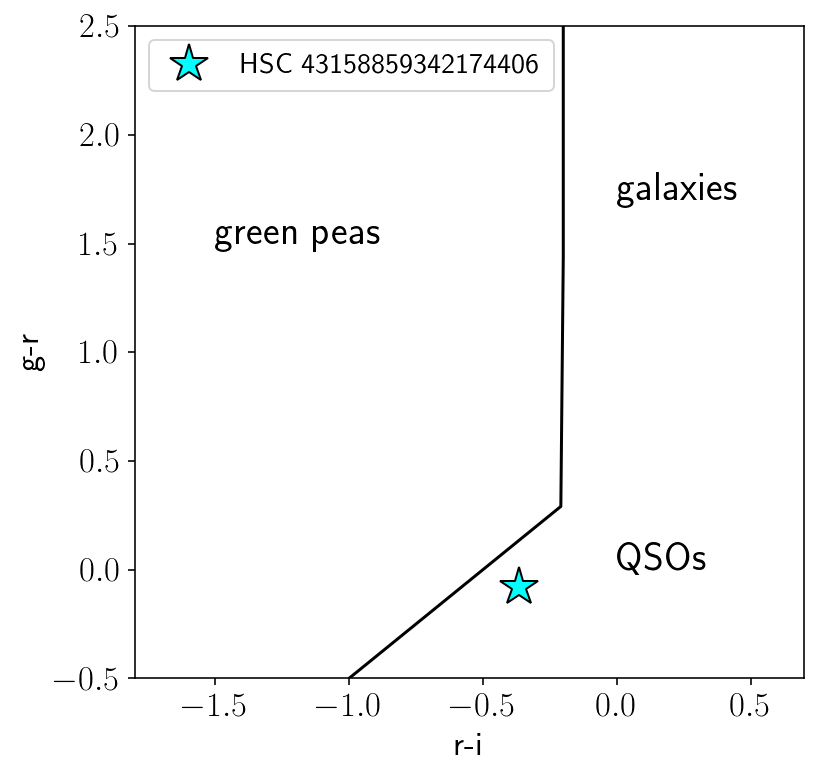

In [28]:
plt.figure(figsize=(6,6))
plt.plot(rmag-imag, gmag-rmag, marker='*', markeredgecolor='black', color='cyan', markersize=20, 
         label='HSC 43158859342174406', ls='None')

rimin, rimax = -1.8, 0.7
grmin, grmax = -0.5, 2.5 
plt.xlim(rimin, rimax)
plt.ylim(grmin, grmax)

gr = np.linspace(grmin, grmax, 100)
ri = np.linspace(rimin, rimax, 100)

ricut = []
grcut = []
for i in range(len(ri)):
    grval = ri[i]+0.5
    if grval<=0.3:
        ricut.append(ri[i])
        grcut.append(grval)
    else:
        ricut.append(-0.2)
        grcut.append(gr[i])
plt.plot(ricut, grcut, color='k')

plt.text(-1.5, 1.5, 'green peas', fontsize=20)
plt.text(0, 1.7, 'galaxies', fontsize=20)
plt.text(0, 0, 'QSOs', fontsize=20)

plt.xlabel("r-i")
plt.ylabel("g-r")
plt.legend()

plt.savefig(f'{plot_dir}/color-color.png', bbox_inches='tight')

## Balmer decrement

In [31]:
print(f"Balmer decrement: {gflux_halpha/gflux_hbeta}")
print(f"Balmer decrement: {flux_halpha/flux_hbeta}")
print(f"Balmer decrement: {ew_halpha/ew_hbeta}")
print("Compare to: 2.86 (in star-forming galaxies, https://arxiv.org/pdf/1109.2597.pdf)")

Balmer decrement: 2.8008129554143286
Balmer decrement: 2.8935632042501527
Balmer decrement: 4.512835157846524
Compare to: 2.86 (in star-forming galaxies, https://arxiv.org/pdf/1109.2597.pdf)
